<a href="https://colab.research.google.com/github/aditya-vaish5/NNFLProject/blob/master/nnfl_termproject_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import train and test data

In [2]:
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi

--2020-05-25 17:14:49--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13603614 (13M) [text/plain]
Saving to: ‘train.en’

train.en            100%[===================>]  12.97M  3.62MB/s    in 3.6s    

2020-05-25 17:14:53 (3.62 MB/s) - ‘train.en’ saved [13603614/13603614]

--2020-05-25 17:14:55--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18074646 (17M) [text/plain]
Saving to: ‘train.vi’

train.vi            100%[===================>]  17.24M  4.25MB/s    in 4.1s    

2020-05-25 17:15:00 (4.25 MB/s) - ‘train.vi’ saved [18074646/18074646]

--2020-0

importing librarires numpy , PyTorch , Pandas , regex , unicodedata and time.

In [0]:
import numpy as np
import csv
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

Saving train and test data in Lists.

In [4]:
source_sent = []
target_sent = []

test_source_sent = []
test_target_sent = []


with open('train.en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        # discarding first 20 translations as there was some
        # english to english translations found in the first few. which are wrong
        if l_i<50:
            continue
        source_sent.append(line)
        
            
with open('train.vi', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        if l_i<50:
            continue
        target_sent.append(line)


with open('tst2013.en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        test_source_sent.append(line)
                    
with open('tst2013.vi', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        test_target_sent.append(line)
            
assert len(source_sent) == len(target_sent),'Source: %d, Target: %d'%(len(source_sent),len(target_sent))
assert len(test_source_sent) == len(test_target_sent), 'Source: %d, Target: %d'%(len(test_source_sent), len(test_target_sent))
print('Sample translations (%d)'%len(source_sent))
for i in range(0,len(source_sent),10000):
    print('(',i,') EN: ', source_sent[i])
    print('(',i,') VI: ', target_sent[i])

Sample translations (133267)
( 0 ) EN:  In each one of those assessments that we write , we always tag on a summary , and the summary is written for a non-scientific audience .

( 0 ) VI:  Trong mỗi bản đánh giá chúng tôi viết , chúng tôi luôn đính kèm một bản tóm lược , được viết cho những độc giả không chuyên về khoa học .

( 10000 ) EN:  This is an area in the prefrontal cortex , a region where we can use cognition to try to overcome aversive emotional states .

( 10000 ) VI:  Đây là một khu vực trong vỏ não trước trán , vùng mà chúng sử dụng tri thức cho việc thử vượt qua trạng thái cảm xúc ác cảm .

( 20000 ) EN:  And there are flowers that are self-infertile . That means they can &apos;t -- the pollen in their bloom can &apos;t fertilize themselves .

( 20000 ) VI:  có những loài hoa không thể tự thụ phấn . Nghĩa là chúng không thể -- phấn hoa của nó không thể tụ thụ phấn được

( 30000 ) EN:  And a lot of this comes together in a philosophy of change that I find really is powerfu

Importing pretrained glove embeddings

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-25 17:08:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-25 17:08:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-25 17:08:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Import gzip for unzipping glove embeddings in runtime.

In [5]:
!apt install gzip
import gzip
!unzip glove*.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gzip is already the newest version (1.6-5ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Current directory structure in Runtime.

In [6]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  train.en  tst2013.en
glove.6B.200d.txt  glove.6B.50d.txt   sample_data   train.vi  tst2013.vi


installing and importing libraries to read glove embeddings.

In [7]:
!pip install bcolz

     |████████████████████████████████| 1.5MB 6.5MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2656151 sha256=eb7dbca078b55a9bcd37f3b3d87a7766b43c8a97c501d54cbe3a95320baa161c
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [0]:
import bcolz
import pickle
import copy
import operator
from pandas import DataFrame

Saving glove embeddings and their values in 2 files for later use.

In [0]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='/content/6B.200.dat', mode='w')
with open('/content/glove.6B.200d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
     
vectors = bcolz.carray(vectors[1:].reshape((400000, 200)), rootdir='/content/6B.200.dat', mode='w')
vectors.flush()
pickle.dump(words, open('/content/6B.200_words.pkl', 'wb'))
pickle.dump(word2idx, open('/content/6B.200_idx.pkl', 'wb'))

Creating a dictionary glove with words mapping to their embeddings.

In [0]:
vectors = bcolz.open('/content/6B.200.dat')[:]
words = pickle.load(open('/content/6B.200_words.pkl', 'rb'))
word2idx = pickle.load(open('/content/6B.200_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

Displaying glove embeddings.

In [11]:
glove_dframe = DataFrame(vectors, columns=range(1,201), index=words)
print(glove_dframe.shape)
glove_dframe[0:10]

(400000, 200)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
the,-0.071549,0.093459,0.023738,-0.090339,0.056123,0.32547,-0.397960,-0.092139,0.061181,-0.189500,0.130610,0.14349,0.011479,0.381580,0.540300,-0.140880,0.243150,0.230360,-0.553390,0.048154,0.456620,3.2338,0.020199,0.049019,-0.014132,0.076017,-0.115270,0.200600,-0.077657,0.243280,0.163680,-0.341180,-0.066070,0.101520,0.038232,-0.176680,-0.88153,-0.33895,-0.035481,-0.550950,...,-0.042910,-0.067897,-0.293320,0.109780,-0.045365,0.232220,-0.311340,-0.289830,-0.666870,0.53097,0.194610,0.366700,0.26185,-0.651870,0.102660,0.113630,-0.129530,-0.682460,-0.187510,0.147600,1.07650,-0.229080,-0.009343,-0.206510,-0.352250,-0.267200,-0.003431,0.25906,0.217590,0.661580,0.121800,0.199570,-0.20303,0.344740,-0.243280,0.131390,-0.008877,0.336170,0.030591,0.255770
",",0.176510,0.292080,-0.002077,-0.375230,0.004914,0.23979,-0.288930,-0.014643,-0.109930,0.155920,0.206270,0.47675,0.099907,-0.140580,0.211140,0.121260,-0.318310,-0.089433,-0.090553,-0.319620,0.213190,2.4844,-0.077521,-0.084279,0.201860,0.260840,-0.404110,-0.191270,0.247150,0.223940,-0.063437,0.203790,-0.184630,-0.088413,0.024169,-0.287690,-0.61246,-0.12683,-0.088273,0.183310,...,0.026823,-0.045444,-0.226420,-0.199770,-0.121380,0.169410,0.061998,0.426310,-0.088383,0.45756,0.077774,0.061342,0.45710,-0.177870,-0.145970,0.326540,0.002443,-0.118860,0.100810,-0.020011,1.03660,-0.398140,-0.681800,0.236850,-0.203960,-0.176680,-0.313850,0.14834,-0.052187,0.061300,-0.325820,0.191530,-0.15469,-0.146790,0.046971,0.032325,-0.220060,-0.207740,-0.231890,-0.108140
.,0.122890,0.580370,-0.069635,-0.502880,0.105030,0.39945,-0.386350,-0.084279,0.122190,0.080312,0.323370,0.47579,-0.038375,-0.007090,0.415240,0.321210,-0.211850,0.361440,-0.055623,-0.030512,0.428540,2.8547,-0.146230,-0.175570,0.311970,-0.131180,0.033298,0.130930,0.089889,-0.124170,0.002340,-0.068954,-0.107540,-0.115510,-0.310520,-0.120970,-0.46691,-0.08360,-0.037664,-0.071779,...,0.075441,0.082116,-0.460080,0.012393,-0.025310,0.141770,-0.092192,0.345050,-0.521360,0.57304,0.011973,0.033196,0.29672,-0.278990,0.199790,0.256660,0.082079,-0.078436,0.093719,0.242020,1.34950,-0.304340,-0.309360,0.420470,-0.079068,-0.148190,-0.089404,0.06680,0.224050,0.272260,-0.035236,0.176880,-0.05360,0.007003,-0.033006,-0.080021,-0.244510,-0.039174,-0.162360,-0.096652
of,0.052924,0.254270,0.313530,-0.356130,0.029629,0.51034,-0.107160,0.151950,0.057698,0.061490,0.061160,0.39911,-0.000290,0.319780,0.432570,-0.147080,0.054842,0.270790,-0.140510,-0.301010,0.163130,3.0013,0.222310,-0.142790,0.083705,0.089866,-0.527060,-0.089661,0.273110,0.314130,-0.040810,0.060557,-0.042656,0.241780,-0.291870,0.225750,-0.62980,-0.14641,-0.224290,-0.056621,...,0.405320,-0.027960,-0.133980,-0.110860,0.059506,0.240520,-0.597390,-0.002407,-0.185930,1.04200,-0.129690,0.208130,0.33305,-0.127800,0.085662,-0.076422,0.314070,-0.237840,-0.054838,0.011369,0.84500,-0.341650,0.093983,0.082445,-0.277770,-0.442260,-0.063078,0.37274,0.054468,0.241970,-0.040886,0.389400,-0.10509,0.233720,0.096027,-0.303240,0.244880,-0.086254,-0.419170,0.464960
to,0.573460,0.541700,-0.234770,-0.362400,0.403700,0.11386,-0.449330,-0.309910,-0.005341,0.584260,-0.025956,0.49393,-0.037209,-0.284280,0.097696,-0.489070,0.026027,0.376490,0.057788,-0.468070,0.081288,3.2825,-0.636900,0.379560,0.003817,0.093607,-0.128550,0.173800,0.105220,0.286480,0.210890,-0.470760,0.027733,-0.198030,0.076328,-0.846290,-0.79708,-0.38743,-0.030422,-0.268490,...,-0.124130,-0.344310,-0.232960,-0.211870,0.085387,0.070063,-0.198030,-0.026023,-0.390370,0.80002,0.405770,-0.079863,0.35263,-0.340430,0.396760,0.228620,-0.350280,-0.473440,0.597420,-0.116570,1.05520,-0.415700,-0.080552,-0.056571,-0.166220,0.192740,-0.095175,-0.20781,0.156200,0.050231,-0.279150,0.437420,-0.31237,0.131940,-

Moving 'sos' token at index 0 and 'eos' token at index 1

In [0]:

sos_index = word2idx['sos']
eos_index = word2idx['eos']
sos_swap_word = words[0]
eos_swap_word = words[1]
 
words[0], words[sos_index] = words[sos_index], words[0]
words[1], words[eos_index] = words[eos_index], words[1]
word2idx[sos_swap_word], word2idx['sos'] = word2idx['sos'], word2idx[sos_swap_word]
word2idx[eos_swap_word], word2idx['eos'] = word2idx['eos'], word2idx[eos_swap_word]

Sorting words in an dictionary.

In [0]:
# Sort Word2idx
word2idx = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}

import matplotlib for plotting graphs and visualization.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
print(device)

cuda


A language class to store all words mapped to an index in the dataset. In this class we also assign all the words in pretrained glove embedding while initializing the language class for english.

In [0]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        if(name == 'eng'):
          self.word2index = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}
          self.word2index["unk"] = 400000 
          self.word2count = { word : 1 for word in words }
          self.index2word = { i : word for word, i in word2idx.items() }
          self.n_words = 400001
        else:
          self.word2index = {}
          self.word2count = {}
          self.index2word = {0: "sos", 1: "eos"}
          self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Preprocessing of sentences to remove all non letter characters and converting sentence to Ascii characters.

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Filtering data with sentences having a  maximum length of 100.

In [0]:
MAX_LENGTH = 100

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Preparing data for for both input and output languages.

In [0]:
def prepareData(lang1, lang2, source_arr, target_arr):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = [];
    for i in range(0,len(target_arr)):
      pairs.append([normalizeString(source_arr[i]), normalizeString(target_arr[i])])
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

Preparing data and removing sentences with word length > 100,

In [22]:
input_lang, output_lang, pairs_train = prepareData('eng', 'vi', source_sent, target_sent)
print(random.choice(pairs_train))

Read 133267 sentence pairs
Trimmed to 132670 sentence pairs
Counting words...
Counted words:
eng 402460
vi 14127
['that was the dogma .', ' o a thanh tin ieu .']


Defining a matrix with glove embedding of size 200 to initialize in Encoder.

In [24]:
# create a new tensor with all embeddings for english using glove dictionary
matrix_len = input_lang.n_words
 
weights_matrix = np.zeros((matrix_len, 200))
words_found = 0
print(input_lang.n_words)
print(len(input_lang.word2index))
for i, word in enumerate(input_lang.word2index):
    try: 
        weights_matrix[i-2] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i-2] = np.random.normal(scale=0.6, size=(200, ))

402460
402459


The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.input_size = input_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional = True)

    def forward(self, input, hidden, cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell_state) = self.lstm(output, (hidden, cell_state))
        return output, hidden, cell_state

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device = device)
    def initcellstate(self):
      return torch.zeros(2, 1, self.hidden_size, device = device)

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation. This class defined a simple decoder without attention.

In [0]:
# THIS CLASS ISN'T USED IN EVALUATION
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,bidirectional =True)
        self.out = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden,cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden,cell_state = self.lstm(output, (hidden,cell_state))
        output = self.softmax(self.out(output[0]))
        return output, hidden,cell_state

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    def initcellstate(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

**Attention decoder**

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs

In [0]:
MAX_LENGTH = 100
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size,bidirectional =True)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, cell_state, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # print(attn_weights.unsqueeze(0).size(), encoder_outputs.unsqueeze(0).size())
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # print(embedded[0].size(),attn_applied[0].size())
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell_state) = self.lstm(output, (hidden, cell_state))

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell_state, attn_weights

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device = device)
    def initcellstate(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

Preparing input tensors and appending **EOS** End of Sentence token.

In [0]:
def indexesFromSentence(lang, sentence):
    arr = [];
    for word in sentence.split(' '):
        try:
          arr.append(lang.word2index[word])
        except:
          arr.append(lang.word2index["unk"])
    return arr

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Traning the model for 1 iteration.

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

In [0]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initcellstate()
    # print("setting optimizers to zero grad")
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # print("INPUT SIZE: ", input_tensor.size())
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)

    loss = 0

    for ei in range(input_length):
      # print("starting encoder for " , ei)
      encoder_output, encoder_hidden, encoder_cell = encoder(
          input_tensor[ei], encoder_hidden, encoder_cell)
      # print(encoder_output)
      encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    for di in range(target_length):
      # print("decoder for di : ", di)
      decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
          decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # detach from history as input

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
          break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
# Helper functions
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Creating training pairs and calling train function for multiple iterations.

Start a timer

Initialize optimizers and criterion

Create set of training pairs

Start empty losses array for plotting

In [0]:
def trainIters(encoder, decoder, n_iters, pairs, print_every=1000, plot_every=100, learning_rate=0.1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]

        input_tensor = training_pair[0]
        target_tensor = training_pair[1]


        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Encoder initialization done
Decoder initialization done
0m 5s (- 1m 43s) (50 5%) 4.2786
0m 11s (- 1m 39s) (100 10%) 3.7148
0m 15s (- 1m 28s) (150 15%) 2.8182
0m 20s (- 1m 21s) (200 20%) 3.4495
0m 26s (- 1m 19s) (250 25%) 2.8874
0m 30s (- 1m 11s) (300 30%) 2.2843
0m 34s (- 1m 4s) (350 35%) 2.8103
0m 38s (- 0m 58s) (400 40%) 2.5427
0m 43s (- 0m 52s) (450 45%) 2.7583
0m 47s (- 0m 47s) (500 50%) 2.4947
0m 52s (- 0m 42s) (550 55%) 2.7759
0m 56s (- 0m 37s) (600 60%) 2.1928
1m 0s (- 0m 32s) (650 65%) 2.9212
1m 6s (- 0m 28s) (700 70%) 3.3000
1m 10s (- 0m 23s) (750 75%) 2.5192
1m 14s (- 0m 18s) (800 80%) 3.0483
1m 19s (- 0m 14s) (850 85%) 2.9457
1m 24s (- 0m 9s) (900 90%) 2.8222
1m 29s (- 0m 4s) (950 95%) 3.4956
1m 34s (- 0m 0s) (1000 100%) 2.6518


<Figure size 432x288 with 0 Axes>

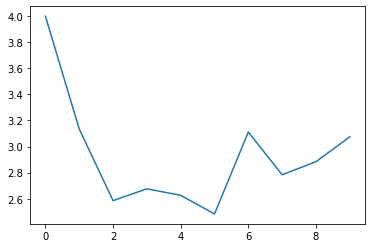

In [69]:
hidden_size = 200
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
print("Encoder initialization done")
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
print("Decoder initialization done")

trainIters(encoder1, attn_decoder1, 1000, pairs_train, print_every=50)

Preparing test data to evaluate our trained network.

In [70]:
input_lang_test, output_lang_test, pairs_test = prepareData('eng', 'vi', test_source_sent, test_target_sent)
print(random.choice(pairs_test))

Read 1268 sentence pairs
Trimmed to 1265 sentence pairs
Counting words...
Counted words:
eng 400032
vi 1104
['so what we can do is use steel wool just to clean pans and the steel wool we can cut in very small pieces and these very small pieces we can mix to the bitumen .', 'nhung gi chung toi co the lam la dung mieng bui nhui bang thep danh e chui rua xoong . va chung toi cat vun mieng bui nhui thep ra that nho va chung toi tron cac manh vun nho nay voi nhua bitum .']


Evalutate fuction runs on encoder then feed the output to decoder. And then turs decoded output into words again for later display.

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initcellstate()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden,encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden,encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden,decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1,:ei + 1]

Picks a random set form test data and call evaluate() on it.

In [77]:
def evaluateRandomly(encoder, decoder, n=10):
    input=[]
    reference=[]
    output=[]
    for i in range(n):
        
        pair = random.choice(pairs_test)
        print('>', pair[0])
        input.append(pair[0])
        reference.append(pair[1])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        output.append(output_sentence)
        print('')
    return output,reference,input



output,reference,input=evaluateRandomly(encoder1, attn_decoder1,5)


> we had these magnificent tomatoes . in italy a tomato would grow to this size . in zambia to this size .
= chung toi co nhung qua ca chua rat tuyet voi . tai y mot qua ca chua chi to khoang bang nay . tai zambia no to toi co nay nay .
< va o co co la toi o co co co co co co co toi o co co co toi o co toi o co co co co co co toi o co co toi o co co toi o co co co co toi o co toi o co co co co toi o co co co co co co co toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the co ban co ban co <EOS>

> we can also act as a bridge between the people inside north korea and the outside world because many of us stay in contact with family members still inside and we send information and money that is helping to change north korea from inside .
= chung toi cung co the ong vai tro nhu cau noi giua nhung nguoi ang o trong bac trieu tien voi the gioi ben ngoai boi vi co rat nhieu nguoi trong chung toi ang giu lien lac voi nhung than

In [73]:
evaluateRandomly(encoder1, attn_decoder1)

> kofi was rescued from a fishing village .
= kofi uoc cuu tu lang chai .
< va co co co la toi o co toi o co co co co toi o co co co toi o co ban co ban co ban co ban co <EOS>

> thank you .
= vo tay cam on
< va co co la toi o co co co co co co co co co co co toi the toi the toi the toi the toi the toi the toi the toi the toi the co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co ban co <EOS>

> many have been tricked by false promises of a good education a better job only to find that they apos re forced to work without pay under the threat of violence and they cannot walk away .
= rat nhieu nguoi bi lua boi nhung loi hua ieu ngoa ve giao duc tot cong viec tot hon chi e thay minh bi bat lam viec khong cong duoi ach bao luc va khong thoat ra uoc .
< va co co co la toi o co toi o co co toi o co co co co toi o co co co toi o co co co co co co co co toi o co toi o co co 

Computing BLEU score using nltk library

In [0]:

from nltk.translate.bleu_score import sentence_bleu
def calc_bleu(reference,nput,output):
 scores=[]
 score=0
 print(score)
 for sentence in range(len(reference)):
   score = sentence_bleu(reference[sentence],output[sentence])
   scores.append(score)
  
 
 for sentence in range(len(reference)):
   print("input sentence: ",nput[sentence])
   print("reference sentence:",reference[sentence])
   print("output sentence:",output[sentence])
   print("BLEU SCORE:",scores[sentence])

 return pd.DataFrame({"input sentence: ":nput,"reference sentence:":reference,"output sentence:":output,"BLEU SCORE:":scores})

In [83]:
calc_bleu(reference,input,output)

0
input sentence:  we had these magnificent tomatoes . in italy a tomato would grow to this size . in zambia to this size .
reference sentence: chung toi co nhung qua ca chua rat tuyet voi . tai y mot qua ca chua chi to khoang bang nay . tai zambia no to toi co nay nay .
output sentence: va o co co la toi o co co co co co co co toi o co co co toi o co toi o co co co co co co toi o co co toi o co co toi o co co co co toi o co toi o co co co co toi o co co co co co co co toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the toi the co ban co ban co <EOS>
BLEU SCORE: 0.4282636687818112
input sentence:  we can also act as a bridge between the people inside north korea and the outside world because many of us stay in contact with family members still inside and we send information and money that is helping to change north korea from inside .
reference sentence: chung toi cung co the ong vai tro nhu cau noi giua nhung nguoi ang o tron

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


,input sentence:,reference sentence:,output sentence:,BLEU SCORE:
0,we had these magnificent tomatoes . in italy a...,chung toi co nhung qua ca chua rat tuyet voi ....,va o co co la toi o co co co co co co co toi o...,0.428264
1,we can also act as a bridge between the people...,chung toi cung co the ong vai tro nhu cau noi ...,va co co co la toi o co toi o co co co co co c...,0.404441
2,and i am on this stage because i am a model .,va toi ung tren san khau nay boi vi toi la mot...,va co co la toi o co co toi o co co co co co c...,0.503534
3,also i realized there was a wide gap between n...,toi cung nhan ra mot khoang cach rat lon giua ...,va o co co la toi o co toi o co co toi o co co...,0.466584
4,and first i commend you on your model knowledg...,toi muon khen ngoi su am hieu ve nguoi mau cua...,va co co co la toi o co co co co co co co toi ...,0.486850


Plotting atention matrices for each output words with all corresspoding inputs.(Zoom in if the sentence is too long or run again to run it on a smaller sentence for better visualization)

input = i want to take shipping containers and turn them into healthy cafes .
output = va o co co la toi o co co co co co co co co toi o co co co toi o co co co co co toi o co toi o co co co co co toi o co ban co <EOS>


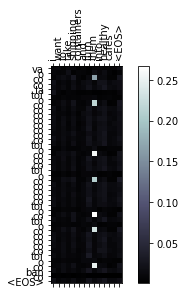

In [74]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(random.choice(pairs_test)[0])
